# EEG classifier

In [49]:
import os
import numpy as np
import time, datetime
import matplotlib.pyplot as plt
from collections import OrderedDict
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [3]:
data_path = "../dataset/"

for dirname, _, filenames in os.walk(data_path):
    for filename in filenames:
        if "train" in filename:
            train_path = os.path.join(dirname, filename)
        if "test" in filename:
            test_path = os.path.join(dirname, filename)

In [4]:
def encode_target(target):
    if target == -55:
        return 0
    else:
        return 1

In [5]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# remove unnamed columns
train_df = train_df.iloc[: , 3:]
test_df = test_df.iloc[: , 3:]

# change target value
train_df.target = train_df.target.apply(encode_target)
test_df.target = test_df.target.apply(encode_target)

In [6]:
train_df.shape

(4803, 201)

In [7]:
test_df.shape

(1177, 201)

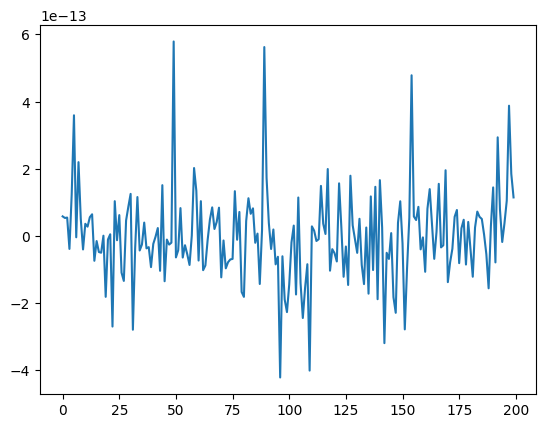

In [8]:
plt.plot(train_df.iloc[2:3, :-1].to_numpy()[0])

In [9]:
# classes
np.unique(train_df.to_numpy()[:,-1])

array([0., 1.])

In [10]:
def print_conf_matrix(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)

    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()

In [11]:
def create_data_loader(train_df, test_df, batch_size = 100, val_split=0.3):
    
    # transform dataframe to numpy array
    train_data = train_df.to_numpy()
    test_data = test_df.to_numpy()
    
    # create x and y
    x_train = train_data[:, :-1]/train_data[:, :-1].max()
    x_test = test_data[:, :-1]/test_data[:, :-1].max()
    y_train = train_data[:, -1]
    y_test = test_data[:, -1]
    
    x_train = x_train[:, :178]
    x_test = x_test[:, :178]

    # create tensor dataset of x and y
    train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_train).float(),
                                                   torch.from_numpy(y_train))
    test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_test).float(),
                                                  torch.from_numpy(y_test))
    
    # split dataset in train, val and test
    train_len = train_data.shape[0]
    val_len = int(train_len * val_split)
    train_len -= val_len

    # shuffle train and validade data
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_len, val_len])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, val_loader, test_loader

In [12]:
batch_size = 8
val_split = 0.2

In [13]:
train_loader, val_loader, test_loader = create_data_loader(train_df, test_df, batch_size = batch_size, val_split=val_split)

In [14]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        
        super(RNNModel, self).__init__()
        
        # Number of hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # RNN
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        
        # Initialize hidden state with zeros
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
            
        # One time step
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :]) 
        return out

In [15]:
num_epochs = 20 # number of training epochs

In [16]:
input_dim = 178   # input dimension
hidden_dim = 1000  # hidden layer dimension
layer_dim = 1     # number of hidden layers
output_dim = 2   # output dimension

# Initiate RNN model
model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.05
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [17]:
test_df.shape[0]//batch_size

147

In [18]:
seq_dim = 178
loss_list = []
iteration_list = []
accuracy_list = []
y_true=[]
y_pred=[]
count = 0
for epoch in range(num_epochs):
    for i, (signals, labels) in enumerate(train_loader):

        train = signals.unsqueeze(1)
        labels = labels.long()
            
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(train)
        
        # Calculate softmax and ross entropy loss
        loss = error(outputs, labels)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        count += 1
        
        if count % (test_df.shape[0]//batch_size) == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for signals, labels in val_loader:
                signals = signals.unsqueeze(1)
                
                # Forward propagation
                outputs = model(signals)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += labels.size(0)
                
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            print('iteration: {}  val_loss: {}  val_accuracy: {} %'.format(count, loss.data, accuracy))

iteration: 147  val_loss: 0.600681483745575  val_accuracy: 56.14583206176758 %
iteration: 294  val_loss: 0.6494925618171692  val_accuracy: 56.14583206176758 %
iteration: 441  val_loss: 0.678249716758728  val_accuracy: 56.14583206176758 %
iteration: 588  val_loss: 0.6202194094657898  val_accuracy: 56.14583206176758 %
iteration: 735  val_loss: 0.6544901132583618  val_accuracy: 58.85416793823242 %
iteration: 882  val_loss: 0.5118415355682373  val_accuracy: 56.14583206176758 %
iteration: 1029  val_loss: 0.6010640263557434  val_accuracy: 72.91666412353516 %
iteration: 1176  val_loss: 0.5947770476341248  val_accuracy: 76.77083587646484 %
iteration: 1323  val_loss: 0.561293363571167  val_accuracy: 61.25 %
iteration: 1470  val_loss: 0.5238454937934875  val_accuracy: 70.10416412353516 %
iteration: 1617  val_loss: 0.5715494751930237  val_accuracy: 68.64583587646484 %
iteration: 1764  val_loss: 0.6819566488265991  val_accuracy: 83.75 %
iteration: 1911  val_loss: 0.5360839366912842  val_accuracy: 

In [19]:
correct = 0
total = 0
y_true = []
y_pred = []
# Test model
for signals, labels in test_loader:
    signals = signals.unsqueeze(1)

    # Forward propagation
    outputs = model(signals)

    # Get predictions from the maximum value
    predicted = torch.max(outputs.data, 1)[1]

    # Total number of labels
    total += labels.size(0)

    correct += (predicted == labels).sum()
    y_true+=labels
    y_pred+=predicted
    
accuracy = 100 * correct / float(total)

# Print validade loss
print('test_accuracy: {} %'.format(accuracy.numpy().round()))

test_accuracy: 89.0 %


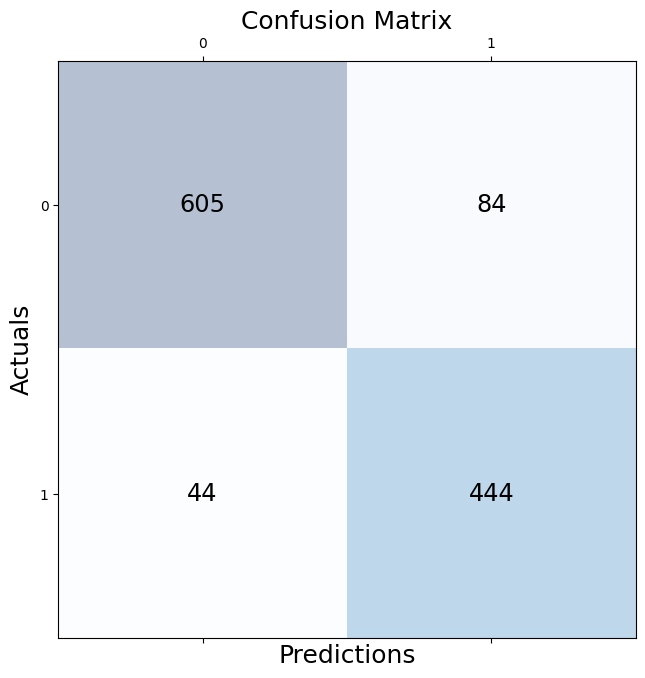

In [20]:
print_conf_matrix(y_true, y_pred)

In [22]:
len(y_pred)

1177

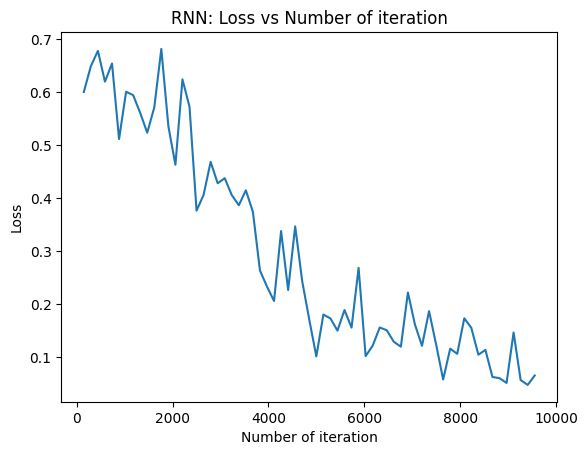

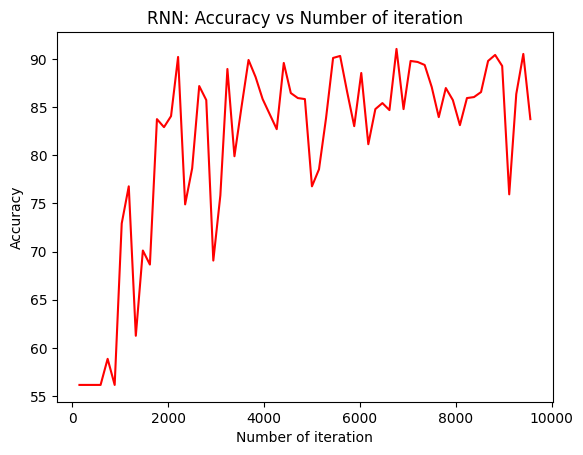

In [21]:
# visualization loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("RNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("RNN: Accuracy vs Number of iteration")
plt.show()

### Test model with an experimental data

In [34]:
def test_data_loader(test_df, batch_size = 100):
    
    # transform dataframe to numpy array
    test_data = test_df.to_numpy()
    
    # create x and y
    x_test = test_data[:, :-1]/test_data[:, :-1].max()
    y_test = test_data[:, -1]

    # create tensor dataset of x and y
    test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_test).float(),
                                                  torch.from_numpy(y_test).long())

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return test_loader

In [35]:
df = pd.read_csv("../dataset/experimental_data.csv")

In [36]:
# Remove first column
final_test_df = df.iloc[: , 1:]

In [37]:
def get_target(target):
    if target==2:
        return 0
    elif target==1:
        return 1
    else:
        return np.nan

In [38]:
# select targets 1 and 2
final_test_df.y = final_test_df.y.apply(get_target)

In [39]:
final_test_df.y.value_counts(dropna=False)

NaN    6900
1.0    2300
0.0    2300
Name: y, dtype: int64

In [40]:
# drop missing values
final_test_df.dropna(subset=["y"], inplace=True)

In [41]:
test_loader = test_data_loader(final_test_df, batch_size = batch_size)

In [42]:
correct = 0
total = 0
y_true = []
y_pred = []
# Test model
for signals, labels in test_loader:
    signals = signals.unsqueeze(1)

    # Forward propagation
    outputs = model(signals)

    # Get predictions from the maximum value
    predicted = torch.max(outputs.data, 1)[1]

    # Total number of labels
    total += labels.size(0)

    correct += (predicted == labels).sum()
    y_true+=labels
    y_pred+=predicted
    
accuracy = 100 * correct / float(total)

# store loss and iteration
# loss_list.append(loss.data)
# accuracy_list.append(accuracy)

# Print validade loss
print('test_accuracy: {} %'.format(accuracy.numpy().round()))

test_accuracy: 89.0 %


In [43]:
len(y_true)

4600

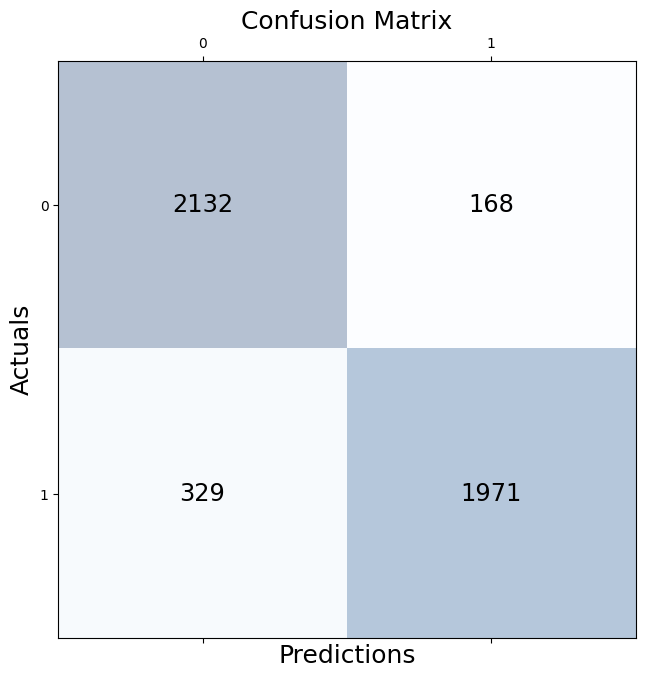

In [44]:
print_conf_matrix(y_true, y_pred)

In [50]:
print(classification_report(y_true, y_pred, target_names=["not seizure","seizure"]))

              precision    recall  f1-score   support

 not seizure       0.87      0.93      0.90      2300
     seizure       0.92      0.86      0.89      2300

    accuracy                           0.89      4600
   macro avg       0.89      0.89      0.89      4600
weighted avg       0.89      0.89      0.89      4600

